# 고양이 수염 스티커 만들기

In [1]:
# 필요 라이브러리 import
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib
import math

print("🌫🛸")

🌫🛸


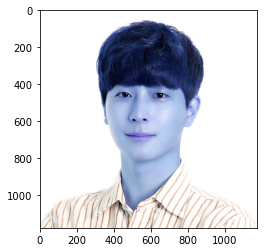

In [2]:
# opencv로 이미지 불러오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/images01.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
#img_bgr = cv2.resize(img_bgr, (img_bgr.shape[0] // 16 * 5, img_bgr.shape[1] // 9 * 5)) # Resize
img_bgr_orig = img_bgr.copy()
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

In [3]:
img_bgr.shape

(1176, 1176, 3)

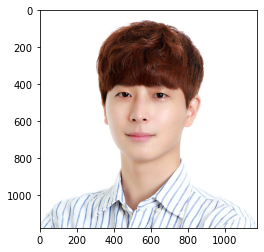

In [4]:
# RGB 변환
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [5]:
# HOG Detector 선언
detector_hog = dlib.get_frontal_face_detector()

In [6]:
# Bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(297, 297) (759, 759)]]


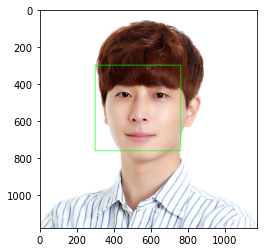

In [7]:
# 찾은 얼굴 영역 좌표
print(dlib_rects)
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [8]:
# landmark model 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [9]:
# landmark 찾기
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

In [10]:
print(len(list_landmarks[0]))

68


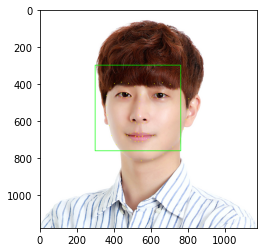

In [11]:
# landmark 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [12]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(531, 566)
(x,y) : (531,566)
(w,h) : (463,463)


(463, 463, 3)


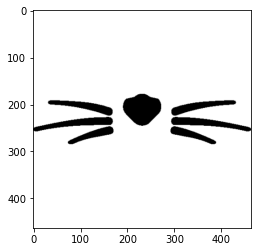

In [13]:
# 스티커 이미지 Read
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
plt.show
print (img_sticker.shape)

In [14]:
# 스티커 이미지 좌표
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (300,335)


In [15]:
# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(463, 463, 3)
(x,y) : (300,335)


In [16]:
# 원본에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

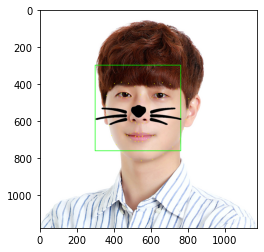

In [17]:
# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

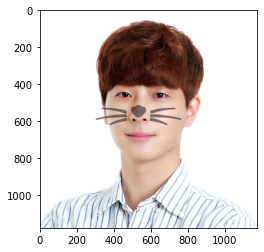

In [18]:
# 불투명도 조절
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

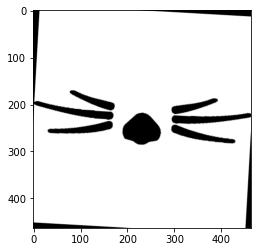

In [19]:
# vector 계산
landmark = list_landmarks[0]
v1 = np.array([0, -1])
v2 = np.array([abs(landmark[33][0] - landmark[27][0]), abs(landmark[33][1] - landmark[27][1])])
unit_vector_1 = v1 / np.linalg.norm(v1)
unit_vector_2 = v2 / np.linalg.norm(v2)
dot_product = np.dot(unit_vector_1, unit_vector_2)
angle = np.arccos(dot_product)

# 회전 변환
rows, cols = img_sticker.shape[:2]
img_sticker_rot = cv2.warpAffine(img_sticker, cv2.getRotationMatrix2D((cols/2, rows/2), math.degrees(angle), 1), (cols, rows))
plt.imshow(img_sticker_rot)
plt.show

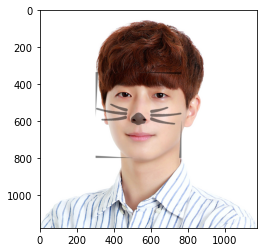

In [20]:
# 불투명도 조절
sticker_area = img_bgr_orig[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker_rot==255,sticker_area,img_sticker_rot).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

회전변환까지는 성공 했는데 회전변환 시 회전한 부분의 이미지가 검은색으로 되어 정상적으로 이미지가 출력되진 않는 것 같다.

# 회고록

오늘 과제는 구현하는 것 까지는 어렵지 않았지만 기능을 추가하면서 어려움을 느꼈다.
특히 투명도를 조절하는 부분이나 각도를 조절하는 부분이 가장 어려웠던 것 같다.
당연하게도 얼굴 각도가 변하면 그에 맞게 스티커도 변형시켜주어야 해서 회전시키는 것 까지는 좋은 시도였으나,
회전시켜야 할 벡터를 잘못 구하였다. 나는 코를 중심으로 스티커를 적용시켰기 때문에 얼굴의 각도에 따라 회전시키면 된다고 생각했다.
따라서 27, 33번 landmark를 두 점으로 하는 벡터에 수직인 벡터를 구한 후 x축에 평행한 벡터와의 각을 구해야 했으나 다른 벡터를 구하고 있었다.
멀리서 촬영한 이미지나 옆으로 누워서 촬영한 이미지는 아무래도 얼굴의 선이나 눈, 코, 입과같은 특징을 찾아내기 어려워서 그런 것 같다.
만약 이것을 실제로 앱으로 만들었을 때, 실행 속도나 정확도는 크게 중요하지 않을 것 같다.
물론 실행 속도가 느리면 느리다고 불평하기야 하겠지만 기능에 문제가 있는 것은 아니니 괜찮지 않을까...?
정확도는 가끔 정확하지 않은 쪽이 더 재미를 주는 경우도 있기 때문에 사람들에게 즐거움을 줄 수 있는 오류라면 괜찮다고 생각한다.
물론 개발자한테는 아니겠지만